# Building Claim Prediction - GENERALI


### ***Alexandre TRENDEL, Nicolas HUBERT***

L’objectif de ce challenge est de prédire si un bâtiment assuré par GENERALI estsusceptible de déposer a minima une réclamation d’assurance durant une période donnée. Il s’agit donc d’un problème de classification supervisée – les valeurs des *targets* binaires à prédire étant conservées par GENERALI.
La métrique retenue pour évaluer la précision avec laquelle les prédictions sont faites est le coefficient normalisé de Gini. La définition donnée pour le challenge est quelque peu différente de la version usuelle, et permet de comparer des probabilités à de vraies *targets*.

Pour plus d'informations sur le challenge et les métriques utilisées, se référer au rapport (format pdf) présent dans le même *repository*.


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [2]:
import numpy as np

def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

# Import des données

## Généralités

In [3]:
train = pd.read_csv("X_train.csv", index_col=0, decimal = ",")
test = pd.read_csv("X_test.csv", index_col=0, decimal = ",")
ytrain = pd.read_csv("y_train_saegPGl.csv", index_col=0, decimal = ",")

train = pd.merge(train, ytrain, on="Identifiant")

print(train.shape)
train.head()

(10229, 26)


,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
0,18702,2014,1.000000,0,V,N,1,O,1,O,...,V,base,2,1351.0,4,2012.0,0.0,2,65440,0
1,3877,2014,1.000000,0,V,V,V,V,V,V,...,N,base,2,1972.0,2,1980.0,0.0,.,14341,1
2,4942,2013,1.000000,1,V,V,V,V,V,V,...,N,base,2,1630.0,4,NaN,0.0,.,75109,0
3,13428,2013,0.246575,0,N,V,V,V,V,V,...,N,base,2,532.0,3,NaN,0.0,.,92004,0
4,17137,2015,1.000000,0,V,N,2,O,1,O,...,V,base,2,1050.0,2,1972.0,0.0,4,59340,0


Une analyse plus fine est nécessaire au vu des nombreuses variables catégorielles.

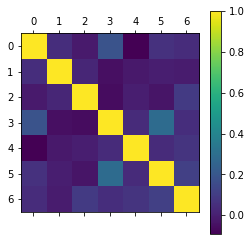

In [4]:
plt.matshow(train.corr())
plt.colorbar()
plt.show()

***Nettoyage des données*** : on enleve les lignes dupliquées s'il y en a, on convertit les types si besoin, et on impute les données manquantes.

In [5]:
def clean_data(df):
    df.drop_duplicates()
    # on ajoute la médiane là où les données sont manquantes
    imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
    df["superficief"] = imp.fit_transform(df[["superficief"]])
    df["ft_22_categ"] = imp.fit_transform(df[["ft_22_categ"]])
    df["ft_22_categ"] = df["ft_22_categ"].astype(int)
    df["superficief"] = df["superficief"].astype(int)
    # département : 2 premiers digits de l'INSEE
    df['dep'] = df['Insee'].apply(lambda x: str(x)[:2]).astype('object')
    df.apply(pd.to_numeric, errors = "ignore")

In [6]:
clean_data(train)
clean_data(test)
train.to_csv('final_train.csv')
train = pd.read_csv("final_train.csv", index_col = 0)

In [7]:
# on enleve insee + target + ... qui vont nous embeter pour la suite
filtered = train.drop(columns = ["Insee", "target", "Identifiant", "dep"])
filtered.head()

,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,...,ft_15_categ,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ
0,2014,1.000000,0,V,N,1,O,1,O,N,...,AUTRE,IDENTIQUE,V,base,2,1351,4,2012,0.0,2
1,2014,1.000000,0,V,V,V,V,V,V,V,...,V,V,N,base,2,1972,2,1980,0.0,.
2,2013,1.000000,1,V,V,V,V,V,V,V,...,V,V,N,base,2,1630,4,1970,0.0,.
3,2013,0.246575,0,N,V,V,V,V,V,V,...,V,V,N,base,2,532,3,1970,0.0,.
4,2015,1.000000,0,V,N,2,O,1,O,N,...,AUTRE,IDENTIQUE,V,base,2,1050,2,1972,0.0,4


In [8]:
train.columns[train.dtypes == 'object']

Index(['ft_5_categ', 'ft_6_categ', 'ft_7_categ', 'ft_8_categ', 'ft_9_categ',
       'ft_10_categ', 'ft_11_categ', 'ft_12_categ', 'ft_13_categ',
       'ft_14_categ', 'ft_15_categ', 'ft_16_categ', 'ft_17_categ',
       'ft_18_categ', 'ft_23_categ', 'ft_24_categ', 'Insee', 'dep'],
      dtype='object')

## One Hot Encoding

One Hot Encoding d'un dataframe Pandas.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# one hot encoding de notre dataframe
# renvoie un dict avec transformer : l'objet transformer
# result : le df nettoyé, sous forme d'array
# names : les colonnes catégorielles traitées
def ohe_df(df):

    cols = list(df.columns)
    names = list(df.columns[df.dtypes == 'object'])
    # pour chacun des types categoriels, on fait du one hot encoding
    transform_cat = [(name, OneHotEncoder(categories = "auto"), [cols.index(name)]) for name in names]

    tr = ColumnTransformer(transform_cat, remainder = 'passthrough')
    tr.fit(df.values)

    return dict(transformer = tr, result = tr.transform(df.values).astype(float), names = names)

res = ohe_df(filtered)
transformed = res["result"]
y = train["target"].values
xtrain, xtest, ytrain, ytest = train_test_split(transformed, y, test_size = 0.2)
res["names"]

['ft_5_categ',
 'ft_6_categ',
 'ft_7_categ',
 'ft_8_categ',
 'ft_9_categ',
 'ft_10_categ',
 'ft_11_categ',
 'ft_12_categ',
 'ft_13_categ',
 'ft_14_categ',
 'ft_15_categ',
 'ft_16_categ',
 'ft_17_categ',
 'ft_18_categ',
 'ft_23_categ',
 'ft_24_categ']

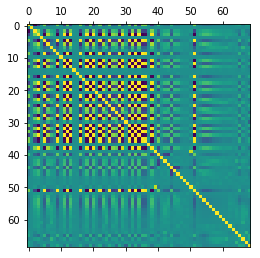

In [10]:
plt.matshow(np.corrcoef(transformed, rowvar = False))
plt.show()

Récupération des slices qui correspondent aux variables catégorielles :

In [11]:
def get_slices(res):
    tr = res["transformer"]
    names = res["names"]

    # nombre de colonnes après encodage = nombre de catégories
    sizes = [0]
    sizes.extend([len(tr.named_transformers_[name].categories_[0]) for name in names])
    sizes = np.array(sizes).cumsum()
    
    # np.s_ crée une slice, utilisable par la suite pour indexer un array
    slices = [np.s_[sizes[i]:sizes[i+1]] for i in range(len(sizes) - 1)]

    return slices, sizes[-1]

names = res["names"]
slices, l = get_slices(res)
cont_names = list(filtered.columns[filtered.dtypes != 'object'])
idcont = list(range(l, l + len(cont_names)))
pd.DataFrame(np.transpose([names+ cont_names, slices + idcont]))

,0,1
0,ft_5_categ,"slice(0, 3, None)"
1,ft_6_categ,"slice(3, 6, None)"
2,ft_7_categ,"slice(6, 10, None)"
3,ft_8_categ,"slice(10, 13, None)"
4,ft_9_categ,"slice(13, 17, None)"
5,ft_10_categ,"slice(17, 20, None)"
6,ft_11_categ,"slice(20, 23, None)"
7,ft_12_categ,"slice(23, 26, None)"
8,ft_13_categ,"slice(26, 29, None)"
9,ft_14_categ,"slice(29, 32, None)"


In [12]:
transformed.shape

(10229, 69)

## Un premier essai de régression logistique

In [13]:
logreg_model = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
logreg_model.fit(xtrain, ytrain)

p1 = logreg_model.predict_proba(xtest)[:,1]
gini_normalized(ytest, p1)

0.39045393672782486

## Suppression de colonnes via GridSearch

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def make_drop(i):
    def drop(x):
        return np.delete(x, i, 1)
    return drop

# pipeline de transformation qui fait la choses suivante : 
# 1. appel à une étape "drop" qui va supprimer certaines features
# 2. regression logistique
pipeline = Pipeline([
    ("drop", FunctionTransformer(validate = False)),
    ("logreg", LogisticRegression(solver = 'lbfgs', max_iter = 1000))
])

# fonctions qui suppriment une feature one hot encoded (donc on supprime une slice)
dropfuns = [make_drop(slice_) for slice_ in slices]

dropfuns.insert(0, make_drop(np.s_[0:62]))
names.insert(0, "drop all categorical")

# le param variable du gridsearch est la fonction de suppression, donc chaque recherche se fait en ayant supprimé une var catégorielle dffierente
params = dict(drop__func = dropfuns) 
search = GridSearchCV(pipeline, params, return_train_score = False, cv = 3, n_jobs = -1)
search.fit(xtrain, ytrain);

In [15]:
pd.DataFrame(search.cv_results_, index = names)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_drop__func,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
drop all categorical,0.131689,0.027537,0.001618,5.334105e-04,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.788490,0.786290,0.784378,0.786386,0.001680,17
ft_5_categ,0.280251,0.051263,0.004323,4.702471e-04,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.790323,0.787757,0.790979,0.789686,0.001390,3
ft_6_categ,0.276261,0.045251,0.004987,5.150430e-07,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.789589,0.787023,0.791713,0.789442,0.001917,6
ft_7_categ,0.225397,0.026923,0.004986,1.408263e-06,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.788123,0.787390,0.785479,0.786997,0.001115,16
ft_8_categ,0.366337,0.139718,0.004987,8.485379e-07,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.789589,0.787023,0.787679,0.788097,0.001089,9
ft_9_categ,0.234706,0.032229,0.005319,4.698532e-04,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.789589,0.787023,0.787679,0.788097,0.001089,9
ft_10_categ,0.273934,0.043627,0.005757,1.089301e-03,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.789589,0.787023,0.791713,0.789442,0.001917,6
ft_11_categ,0.321817,0.017930,0.003978,8.143308e-04,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.793622,0.787023,0.791713,0.790786,0.002772,1
ft_12_categ,0.472180,0.035200,0.004958,7.781710e-04,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.788856,0.788490,0.786579,0.787975,0.000999,12
ft_13_categ,0.363923,0.097359,0.005908,1.116044e-03,<function make_drop.<locals>.drop at 0x0000028...,{'drop__func': <function make_drop.<locals>.dr...,0.788856,0.787023,0.786945,0.787608,0.000883,15


In [16]:
best = search.best_estimator_
rem = names[dropfuns.index(best.get_params()['drop__func'])]
rem, gini_normalized(ytest, best.predict_proba(xtest)[:,1])

('ft_11_categ', 0.38793449450213185)

Finalement, enlever tout le catégoriel ne change pas grand chose...

## Tests de Student pour la sélection avant encodage

(10229, 20)

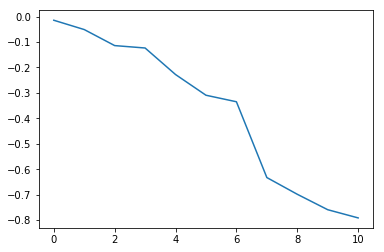

In [17]:
from scipy.stats import ttest_ind
from itertools import combinations

# suppression de colonnes "greedy"
# renvoie tuple
# (path, dropped, df)
# path : pvalue de la colonne supprimée à chaque étape
# dropped : tableaux avec les noms des colonnes supprimées
# df : tableau allégé, de taille k 
def greedy_tt(df, k, threshold = 0.05):
    cat_var = (df.dtypes == 'object').values
    k = max(cat_var.sum() - k, 0)
    names = list(df.iloc[:,cat_var].columns)
    dropped = []
    path = []
    # jusqu'a ce qu'on ait supprimé k colonnes
    for i in range(k):
        pvals = ttest(df)
        # on regarde la colonne pour laquelle le test a donné une val importante
        m = max(pvals)
        path.append(m)
        # si pval pas assez grande ou = na on s'arrete la
        if m != m or m < threshold:
            break
        # sinon, on va supprimer la colonne correspondante
        rem = pvals.index(m)
        dropped.append(names[rem])
        df = df.drop(columns = [names[rem]])
        names.pop(rem)
    return path, dropped, df

# test de student pour chaque niveau de chaque variable catégorielle
def ttest(df):
    l = []
    cat_var = (df.dtypes == 'object').values
    only_num = df.iloc[:,~cat_var]
    # pour chaque colonne catégorielle
    for column in df.iloc[:, cat_var]:
        levels = df[column].astype('category').cat.categories
        pval = 0
        # pour chaque couple de niveaux
        for level_a, level_b in combinations(levels, r = 2):
            # test de student
            test = ttest_ind(only_num[df[column] == level_a].values, 
                             only_num[df[column] == level_b].values,
                             axis = None)
            # on garde la pvalue la plus importante pour une colonne
            pval = max(test.pvalue, pval)
        l.append(pval)
    return l


path, dropped, df = greedy_tt(filtered, 5)
transformed = ohe_df(df)["result"]

plt.plot(np.log(path))
transformed.shape

## Ajustements de modèles

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(transformed, y, test_size = 0.2)

### Régression logistique

In [19]:
logreg_model = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
logreg_model.fit(xtrain, ytrain)

p1 = logreg_model.predict_proba(xtest)[:,1]
gini_normalized(ytest, p1)

0.3745054170657107

In [20]:
ytest

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

### XGBoost

In [21]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(xtrain, ytrain)

p1 = xgb_model.predict_proba(xtest)[:,1]
gini_normalized(ytest, p1)

0.42366235765217675

Peut on améliorer cela par validation croisée ?

In [22]:
search = GridSearchCV(XGBClassifier(), n_jobs = 4, cv = 5, return_train_score = False, param_grid = dict(
    max_depth = [3, 5, 7],
    learning_rate = [0.01, 0.05, 0.1],
))
search.fit(xtrain, ytrain)
p1 = search.best_estimator_.predict_proba(xtest)[:,1]
gini_normalized(ytest, p1)

0.4239431787625061

In [23]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.374052,0.034575,0.013365,0.002326,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",0.788027,0.778253,0.792914,0.782529,0.781651,0.784676,0.005179,6
1,3.378766,0.064752,0.022939,0.009009,0.01,5,"{'learning_rate': 0.01, 'max_depth': 5}",0.784973,0.777642,0.794136,0.786805,0.793884,0.787486,0.006145,4
2,4.973105,0.134218,0.033909,0.009206,0.01,7,"{'learning_rate': 0.01, 'max_depth': 7}",0.780696,0.775199,0.793525,0.785583,0.784709,0.783942,0.006036,8
3,2.444265,0.117161,0.016755,0.006162,0.05,3,"{'learning_rate': 0.05, 'max_depth': 3}",0.787416,0.782529,0.794136,0.786805,0.792049,0.788586,0.004099,3
4,3.374178,0.049544,0.030120,0.005998,0.05,5,"{'learning_rate': 0.05, 'max_depth': 5}",0.786194,0.778864,0.794136,0.789859,0.796330,0.789075,0.006187,1
5,4.433346,0.041609,0.034308,0.001620,0.05,7,"{'learning_rate': 0.05, 'max_depth': 7}",0.780086,0.778864,0.787416,0.787416,0.789602,0.784676,0.004339,6
6,2.371641,0.050073,0.013908,0.001047,0.1,3,"{'learning_rate': 0.1, 'max_depth': 3}",0.786805,0.781918,0.794136,0.786805,0.795107,0.788953,0.004969,2
7,3.280229,0.030356,0.023155,0.002377,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",0.782529,0.777031,0.792303,0.790470,0.791437,0.786753,0.005982,5
8,3.843723,0.580263,0.026728,0.007148,0.1,7,"{'learning_rate': 0.1, 'max_depth': 7}",0.778864,0.775809,0.783140,0.785583,0.790214,0.782720,0.005042,9


Même chose sur les données de test, pour soumission.

In [24]:
test_f = test.drop(columns = ['Insee', 'Identifiant']).drop(columns = dropped)
test_f.head()
transformed = ohe_df(test_f)["result"]

xgt = XGBClassifier(**search.best_params_)
xgt.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

## ACP pour sélection de variables

<BarContainer object of 20 artists>

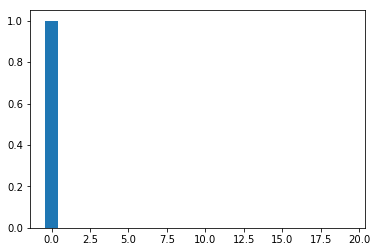

In [25]:
k = 20
xpca = ohe_df(filtered)["result"]
pca = PCA(n_components = k)
pca.fit(xpca, y)
plt.bar(np.arange(k), pca.explained_variance_ratio_)

In [26]:
np.arange(xpca.shape[1])[pca.components_[0,:] > 0.001], pca.components_[0,pca.components_[0,:] > 0.001]

(array([66, 68]), array([0.9999967 , 0.00256434]))

<BarContainer object of 69 artists>

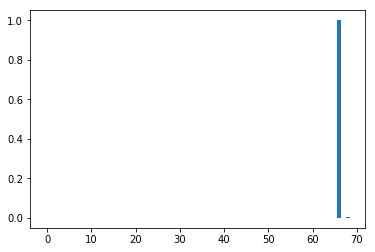

In [27]:
plt.bar(np.arange(xpca.shape[1]), (pca.components_[0,:]))

# Données externes
## Traitement

Lecture du jeu de données (4 Go).

In [28]:
import csv

def splitted_lines(reader):
    # on garde colonne 0 et de 15 à 23
    yield from map(lambda n: [n[0]] + n[15:23], reader)

def line_parser(reader):
    header = next(reader)
    yield header
    real_len = len(header)
    yield from filter(lambda line: real_len == len(line), reader)

def read_full():
    with open("meteo_full.csv") as meteo_full:
        # csv reader va permettre de charger une ligne à la fois en mémoire
        # on ne garde ensuite que les colonnes qui nous intéressent
        reader = splitted_lines(csv.reader(meteo_full, quoting = csv.QUOTE_ALL, delimiter = ';'))
        yield from line_parser(reader)

# ne pas lancer a chaque fois !
if False:
    meteo_full = read_full()
    header = next(meteo_full)
    meteo_full = pd.DataFrame([line for line in meteo_full], columns = header)
    meteo_full.to_csv("meteo_full_nogeo.csv")

Jeu allégé :

In [29]:
meteo_full = pd.read_csv("meteo_full_nogeo.csv")

## Construction d'une variable

In [30]:
# calcul d'un coeff météorologique pour un tableau issu d'un groupement
def coeff_meteo_event(df, weights):
    a, b = weights
    jaune = np.sum(df.values[:, 1:] == "Jaune")
    orange = np.sum(df.values[:, 1:] == "Orange")
    return (a * jaune + b * orange)/df.shape[1] 

# récupère un dataframe avec deux colonnes à partir du jeu de données et de poids à attribuer aux événements jaune et orange
def get_meteo(weights = [0.5, 1]):
    coeffs = []
    grouped = meteo_full.groupby("Code département")
    for key, val in grouped.groups.items():
        if key == '': continue
        df = meteo_full.iloc[val]
        coeffs.append((key, coeff_meteo_event(df, weights)))
    return pd.DataFrame(coeffs, columns = ["dep", "meteo"])

meteo = get_meteo()
meteo.head()

,dep,meteo
0,01,5.75
1,02,20.00
2,03,3.70
3,04,9.95
4,05,12.35


In [31]:
# jointure d'un jeu de données sur colonne département (calculée à partir de l'INSEE, cf début)
def merge_meteo(df, weights = [0.5, 1]):
    merged = df.merge(get_meteo(weights), on = 'dep', how = 'left')
    # on complète avec la valeur médiane si pas de code INSEE
    imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
    merged['meteo'] = imp.fit_transform(merged[['meteo']])
    merged = merged.drop(columns = ['Insee', 'dep', 'Identifiant', 'target'], errors = 'ignore')
    return merged

train_meteo = merge_meteo(train)

In [32]:
train_meteo.dtypes

ft_2_categ       int64
EXPO           float64
ft_4_categ       int64
ft_5_categ      object
ft_6_categ      object
ft_7_categ      object
ft_8_categ      object
ft_9_categ      object
ft_10_categ     object
ft_11_categ     object
ft_12_categ     object
ft_13_categ     object
ft_14_categ     object
ft_15_categ     object
ft_16_categ     object
ft_17_categ     object
ft_18_categ     object
ft_19_categ      int64
superficief      int64
ft_21_categ      int64
ft_22_categ      int64
ft_23_categ     object
ft_24_categ     object
meteo          float64
dtype: object

In [33]:
train_meteo.head()

,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,...,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,meteo
0,2014,1.000000,0,V,N,1,O,1,O,N,...,IDENTIQUE,V,base,2,1351,4,2012,0.0,2,7.00
1,2014,1.000000,0,V,V,V,V,V,V,V,...,V,N,base,2,1972,2,1980,0.0,.,7.90
2,2013,1.000000,1,V,V,V,V,V,V,V,...,V,N,base,2,1630,4,1970,0.0,.,5.80
3,2013,0.246575,0,N,V,V,V,V,V,V,...,V,N,base,2,532,3,1970,0.0,.,2.05
4,2015,1.000000,0,V,N,2,O,1,O,N,...,IDENTIQUE,V,base,2,1050,2,1972,0.0,4,15.20


In [34]:
res = ohe_df(train_meteo)
transformed = res["result"]
y = train["target"].values
pd.DataFrame(np.transpose([get_slices(res)[0], res["names"]]))

,0,1
0,"slice(0, 3, None)",ft_5_categ
1,"slice(3, 6, None)",ft_6_categ
2,"slice(6, 10, None)",ft_7_categ
3,"slice(10, 13, None)",ft_8_categ
4,"slice(13, 17, None)",ft_9_categ
5,"slice(17, 20, None)",ft_10_categ
6,"slice(20, 23, None)",ft_11_categ
7,"slice(23, 26, None)",ft_12_categ
8,"slice(26, 29, None)",ft_13_categ
9,"slice(29, 32, None)",ft_14_categ


In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(transformed, y, test_size = 0.2)
xtrain[:, -1]

array([8.9 , 5.8 , 3.7 , ..., 4.8 , 9.2 , 1.75])

## Analyse via PCA

La variable ainsi construite est-elle utile ?

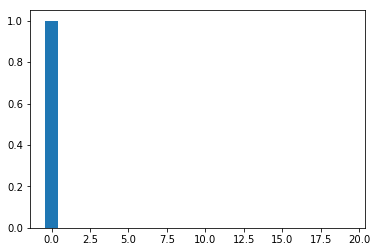

In [36]:
k = 20
pca = PCA(n_components = k)
pca.fit(xtrain, ytrain)
plt.bar(np.arange(k), pca.explained_variance_ratio_)

xtrain_pca = pca.transform(xtrain)
xtest_pca = pca.transform(xtest)

<BarContainer object of 70 artists>

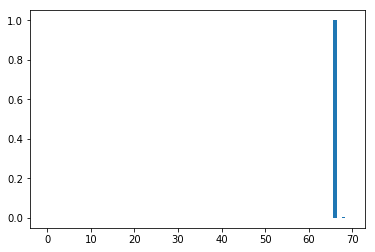

In [37]:
 plt.bar(np.arange(70), pca.components_[0, :])

Il ne semble pas...

## Validation croisée sur poids des événements météorologiques

In [38]:
from sklearn.model_selection import KFold

xgparams = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
kf = KFold(n_splits = 5, shuffle = True)

# on va tester ces poids pour notre nouvelle variable 'meteo'
weights = [(0.5, 0.5), (0.5, 1), (0.7, 1), (3, 3), (0, 1), (1, 0), (0, 0)]

for w in weights:
    new_data = ohe_df(merge_meteo(train, w))['result']
    w_score = []
    print("Test de ({}, {})".format(*w))
    # on teste en ajustant un modèle XGBoost, par validation croisée
    for idtrain, idtest in kf.split(new_data, y):
        xgb = XGBClassifier(**xgparams)
        xgb.fit(new_data[idtrain], y[idtrain])
        p = xgb.predict_proba(new_data[idtest])[:,1]
        score = gini_normalized(y[idtest], p)
        w_score.append(score)
    w_score = np.array(w_score)
    print("Score : {:1.3f} +/- {:1.3f}".format(w_score.mean(), w_score.std()))

Test de (0.5, 0.5)
Score : 0.430 +/- 0.014
Test de (0.5, 1)
Score : 0.434 +/- 0.016
Test de (0.7, 1)
Score : 0.433 +/- 0.028
Test de (3, 3)
Score : 0.438 +/- 0.017
Test de (0, 1)
Score : 0.436 +/- 0.025
Test de (1, 0)
Score : 0.434 +/- 0.026
Test de (0, 0)
Score : 0.431 +/- 0.016


***Résultat*** : Définitivement aucun intérêt...

## Ajustement de modèles

In [39]:
xgb_model = XGBClassifier()
xgb_model.fit(xtrain, ytrain)

p1 = xgb_model.predict_proba(xtest, validate_features = False)[:,1]
gini_normalized(ytest, p1)

0.4380086830037418

In [40]:
test_meteo = merge_meteo(test)
xtest_real = ohe_df(test_meteo)['result']

# Soumission
proba = xgb_model.predict_proba(xtest_real, validate_features = False)[:,1]
pd.DataFrame(dict(Identifiant = test["Identifiant"], target = proba)).to_csv("sub2.csv")

Grid search à nouveau :

In [41]:
search = GridSearchCV(XGBClassifier(), n_jobs = 4, cv = 5, return_train_score = False, param_grid = dict(
    max_depth = [2, 3, 5],
    n_estimators = [50, 100, 200],
    learning_rate = [0.01, 0.05, 0.1],
))
search.fit(xtrain, ytrain)

p1 = search.best_estimator_.predict_proba(xtest)[:,1]
gini_normalized(ytest, p1)

0.4360405725008606

In [42]:
search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}

In [43]:
proba = search.best_estimator_.predict_proba(xtest_real, validate_features = False)[:,1]
pd.DataFrame(dict(Identifiant = test["Identifiant"], target = proba)).to_csv("sub3.csv")